In [2]:
import xarray as xr
import numpy as np
from xgcm.grid import Grid
from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
from glob import glob
from matplotlib.colors import LogNorm
import matplotlib.patches as patches
import xrft

In [2]:
# Load velocities
vels_filtered = xr.open_zarr('/swot/SUM03/spencer/hourly_filt/filtered_vels.zarr')
vels_unfiltered = xr.open_zarr('/swot/SUM03/spencer/hourly_filt/unfiltered_vels.zarr')
eta_filtered = xr.open_zarr('/swot/SUM03/spencer/hourly_filt/filtered_eta_nom.zarr')
eta_unfiltered = xr.open_zarr('/swot/SUM03/spencer/hourly_filt/unfiltered_eta_nom.zarr')

uvel_eul = xr.open_zarr('/swot/SUM01/spencer/swot_agulhas_surf/uvel_centered.zarr').sel(k=0)
vvel_eul = xr.open_zarr('/swot/SUM01/spencer/swot_agulhas_surf/vvel_centered.zarr').sel(k=0)
eta_eul = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/eta.zarr')

uvel_eul = uvel_eul.isel(time=slice(1,2000))
vvel_eul = vvel_eul.isel(time=slice(1,2000))
eta_eul = eta_eul.isel(time=slice(1,2000))

u_filtered = vels_filtered.u.isel(time=slice(2,110))
v_filtered = vels_filtered.v.isel(time=slice(2,110))
ssh_filtered = eta_filtered.eta.isel(time=slice(2,110))

u_unfiltered = vels_unfiltered.u.isel(time=slice(2,110))
v_unfiltered = vels_unfiltered.v.isel(time=slice(2,110))
ssh_unfiltered = eta_unfiltered.eta.isel(time=slice(2,110))

ds = xr.open_zarr('/swot/SUM01/spencer/36hr_timeseries/rechunked_6048.zarr')
ds = ds.isel(niter=slice(1,74))
ds['time'] = ds['niter']*3600/144
ds = ds.assign_coords({"time": ds.time})
ds = ds.swap_dims({"niter": "time"})
ds = ds.where(ds.u!=-999)

grid = Grid(u_filtered, coords={'X': {'center': 'i', 'left': 'i_g'}, 'Y': {'center': 'j', 'left': 'j_g'}})

In [3]:
def lanczos(x, a):
    return np.sinc(x/a)
def sinc2(x, a):
    return np.sinc(x/a)

YC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/YC.data', dtype='>f4')
f = 2*2*np.pi/24/3600*np.sin(YC.reshape(2160,2160)[:,0]*np.pi/180)
window_width=72
weight = xr.DataArray(sinc2(np.expand_dims(np.arange(-window_width/2,window_width/2),1),np.expand_dims(np.pi/f/3600*1.1,0)), dims=['window','j'])
#weight = xr.DataArray(sinc2(np.arange(-window_width/2,window_width/2), window_width/2), dims=['window'])
nofiles=36#u_unfiltered.time.shape[0]
u_eul_filtered = uvel_eul.U.chunk({'time':-1}).rolling(time=window_width, center=True).construct('window').dot(weight,dims='window')/weight.sum('window')
v_eul_filtered = vvel_eul.V.chunk({'time':-1}).rolling(time=window_width, center=True).construct('window').dot(weight,dims='window')/weight.sum('window')
eta_eul_filtered = eta_eul.Eta.chunk({'time':-1}).rolling(time=window_width, center=True).construct('window').dot(weight,dims='window')/weight.sum('window')
u_eul_filtered = u_eul_filtered.isel(time=slice(44,44+nofiles)).assign_coords({'time':np.arange(0,nofiles)*3600})
v_eul_filtered = v_eul_filtered.isel(time=slice(44,44+nofiles)).assign_coords({'time':np.arange(0,nofiles)*3600})
eta_eul_filtered = eta_eul_filtered.isel(time=slice(44,44+nofiles)).assign_coords({'time':np.arange(0,nofiles)*3600})
uvel_eul = uvel_eul.isel(time=slice(44,44+nofiles)).assign_coords({'time':np.arange(0,nofiles)*3600})
vvel_eul = vvel_eul.isel(time=slice(44,44+nofiles)).assign_coords({'time':np.arange(0,nofiles)*3600})
eta_eul = eta_eul.isel(time=slice(44,44+nofiles)).assign_coords({'time':np.arange(0,nofiles)*3600})

In [4]:
def lanczos(x, a):
    return np.sinc(x/a)

window_width=72
weight = xr.DataArray(sinc2(np.expand_dims(np.arange(-window_width/2,window_width/2),1),np.expand_dims(np.pi/f/3600*1.1,0)), dims=['window','y0'])

windowed_u = ds.u.rolling(time=window_width, center=True).construct('window').dot(weight,dims='window')/weight.sum('window')

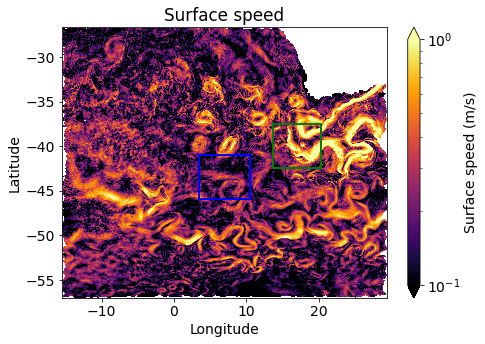

In [13]:
plt.figure(figsize=(7,5))
from matplotlib.colors import LogNorm
(np.sqrt(u_unfiltered**2+v_unfiltered**2)).where(np.sqrt(u_filtered**2+v_filtered**2)>0).isel(time=0).rename('Surface speed (m/s)').plot.pcolormesh(
        x='x0',y='y0',norm=LogNorm(),vmin=10**-1,vmax=1,rasterized=True,cbar_kwargs={'extend':'both'}, cmap='inferno')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('')

ax=plt.gca()
rect = patches.Rectangle((3.538, -45.945), 6.945, 4.897, linewidth=2, edgecolor='b', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

rect = patches.Rectangle((13.728, -42.427), 6.544, 4.895, linewidth=2, edgecolor='g', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)
plt.title('Surface speed')

plt.tight_layout()
fig = plt.gcf()
fig.savefig("unfiltered.png")

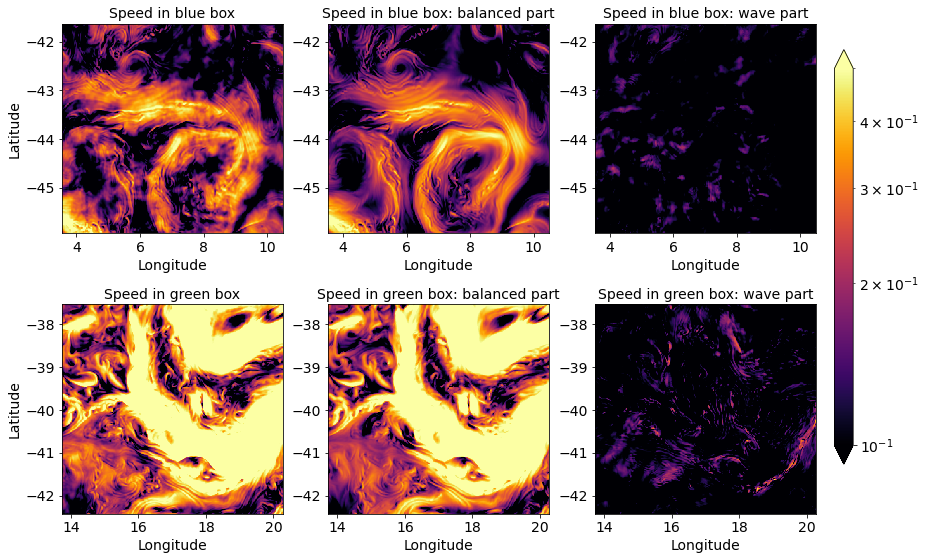

In [18]:
plt.figure(figsize=(13,8))
from matplotlib.colors import LogNorm
plt.subplot(231)
(np.sqrt(u_unfiltered**2+v_unfiltered**2)).where(np.sqrt(u_filtered**2+v_filtered**2)>0).isel(time=0).rename('Surface speed (m/s)').plot.pcolormesh(
        x='x0',y='y0',norm=LogNorm(),vmin=10**-1,vmax=0.5,rasterized=True,add_colorbar=False, cmap='inferno')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Speed in blue box',fontsize=14)
plt.xlim(3.538,10.483)
plt.ylim(-45.94,-41.64)

plt.subplot(232)
(np.sqrt(u_filtered**2+v_filtered**2)).where(np.sqrt(u_filtered**2+v_filtered**2)>0).isel(time=0).rename('Surface speed (m/s)').plot.pcolormesh(
        x='x0',y='y0',norm=LogNorm(),vmin=10**-1,vmax=0.5,rasterized=True,add_colorbar=False, cmap='inferno')
plt.xlabel('Longitude')
plt.ylabel('')
plt.title('Speed in blue box: balanced part',fontsize=14)
plt.xlim(3.538,10.483)
plt.ylim(-45.94,-41.64)

plt.subplot(233)
cs = (np.sqrt((u_unfiltered-u_filtered)**2+(v_unfiltered-v_filtered)**2)).where(np.sqrt(u_filtered**2+v_filtered**2)>0).isel(time=0).rename('Surface speed (m/s)').plot.pcolormesh(
        x='x0',y='y0',norm=LogNorm(),vmin=10**-1,vmax=0.5,rasterized=True,add_colorbar=False, cmap='inferno')
plt.xlabel('Longitude')
plt.ylabel('')
plt.title('Speed in blue box: wave part',fontsize=14)
plt.xlim(3.538,10.483)
plt.ylim(-45.94,-41.64)


plt.subplot(234)
(np.sqrt(u_unfiltered**2+v_unfiltered**2)).where(np.sqrt(u_filtered**2+v_filtered**2)>0).isel(time=0).rename('Surface speed (m/s)').plot.pcolormesh(
        x='x0',y='y0',norm=LogNorm(),vmin=10**-1,vmax=0.5,rasterized=True,add_colorbar=False, cmap='inferno')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Speed in green box',fontsize=14)
plt.xlim(13.728,20.272)
plt.ylim(-42.427,-37.532)

plt.subplot(235)
(np.sqrt(u_filtered**2+v_filtered**2)).where(np.sqrt(u_filtered**2+v_filtered**2)>0).isel(time=0).rename('Surface speed (m/s)').plot.pcolormesh(
        x='x0',y='y0',norm=LogNorm(),vmin=10**-1,vmax=0.5,rasterized=True,add_colorbar=False, cmap='inferno')
plt.xlabel('Longitude')
plt.ylabel('')
plt.title('Speed in green box: balanced part',fontsize=14)
plt.xlim(13.728,20.272)
plt.ylim(-42.427,-37.532)

plt.subplot(236)
cs = (np.sqrt((u_unfiltered-u_filtered)**2+(v_unfiltered-v_filtered)**2)).where(np.sqrt(u_filtered**2+v_filtered**2)>0).isel(time=0).rename('Surface speed (m/s)').plot.pcolormesh(
        x='x0',y='y0',norm=LogNorm(),vmin=10**-1,vmax=0.5,rasterized=True,add_colorbar=False, cmap='inferno')
plt.xlabel('Longitude')
plt.ylabel('')
plt.title('Speed in green box: wave part',fontsize=14)
plt.xlim(13.728,20.272)
plt.ylim(-42.427,-37.532)

fig=plt.gcf()
plt.tight_layout()
fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.9, 0.18, 0.02, 0.72])
fig.colorbar(cs, cax=cbar_ax,extend='both')
fig = plt.gcf()
fig.savefig("unfiltered_zoom.png")

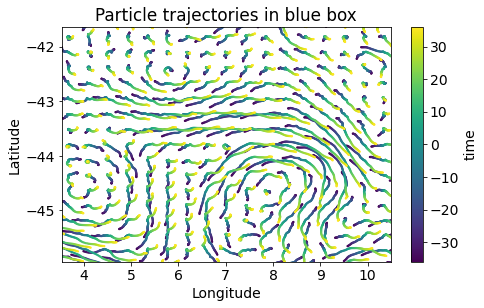

In [19]:
plt.figure(figsize=(7,4.5))
#ds.isel(z0=3,y0=slice(500,2000),x0=slice(0,1000)).plot.scatter(x='x0', y='y0',hue='z0',cmap='binary', s=0.1,vmax=-0.4,vmin=-10,add_guide=False)
ds.isel(x0=np.arange(0,2160,20),y0=np.arange(0,2160,20),z0=3).assign_coords(time=ds.time/3600).plot.scatter(x='x', y='y', hue='time',cmap='viridis', s=1.6)
plt.xlim(3.538,10.483)
plt.ylim(-45.94,-41.64)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Particle trajectories in blue box')

#ax=plt.gca()
#rect = patches.Rectangle((-0.3, -33.1), 0.5, 0.4, linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
#ax.add_patch(rect)

plt.tight_layout()
fig = plt.gcf()
fig.savefig("particle_traj.png")

In [3]:
#consolidate data
vels_filtered = xr.open_zarr('/swot/SUM03/spencer/hourly_filt/filtered_vels.zarr')
vels_unfiltered = xr.open_zarr('/swot/SUM03/spencer/hourly_filt/unfiltered_vels.zarr')
eta_filtered = xr.open_zarr('/swot/SUM03/spencer/hourly_filt/filtered_eta_nom.zarr')
eta_unfiltered = xr.open_zarr('/swot/SUM03/spencer/hourly_filt/unfiltered_eta_nom.zarr')

In [6]:
eta_filtered

<xarray.Dataset>
Dimensions:  (i: 2160, j: 2160, time: 170)
Coordinates:
    niter    int64 ...
  * time     (time) int64 139936661208072 0 3600 7200 ... 597600 601200 604800
    x0       (i) float64 dask.array<chunksize=(2160,), meta=np.ndarray>
    y0       (j) float64 dask.array<chunksize=(2160,), meta=np.ndarray>
    z0       float64 ...
Dimensions without coordinates: i, j
Data variables:
    eta      (time, i, j) float64 dask.array<chunksize=(1, 180, 180), meta=np.ndarray>

In [5]:
vels_unfiltered

<xarray.Dataset>
Dimensions:  (i: 2160, j: 2160, time: 170)
Coordinates:
    niter    int64 ...
  * time     (time) int64 139936661208072 0 3600 7200 ... 597600 601200 604800
    x0       (i) float64 dask.array<chunksize=(2160,), meta=np.ndarray>
    y0       (j) float64 dask.array<chunksize=(2160,), meta=np.ndarray>
    z0       float64 ...
Dimensions without coordinates: i, j
Data variables:
    u        (time, i, j) float64 dask.array<chunksize=(1, 180, 180), meta=np.ndarray>
    v        (time, i, j) float64 dask.array<chunksize=(1, 180, 180), meta=np.ndarray>